In [ ]:
%load_ext autoreload
%autoreload 2
import os
if not os.path.exists('./modules') and not os.path.exists('modules.zip'):
    from google.colab import files
    uploaded = files.upload()
if not os.path.exists('./modules') and os.path.exists('modules.zip'):
    os.system('unzip modules.zip -d .')

!pip3 install optuna
!pip3 install kymatio
import torch
import torch.nn as nn
import optuna
from modules import Trainer
from modules.competition_dataset import EEGDataset, LABELS
from modules.utils import split_and_get_loaders, evaluate_model, get_closest_divisor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import numpy as np
from sklearn.manifold import TSNE
from torchsummary import summary
from sklearn.feature_selection import f_classif

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cpu')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# data_path = '/content/drive/MyDrive/ai_data/eeg_detection/data/mtcaic3'
# model_path = '/content/drive/MyDrive/ai_data/eeg_detection/checkpoints/ssvep/models/ssvep.pth'
# optuna_db_path = '/content/drive/MyDrive/ai_data/eeg_detection/checkpoints/ssvep/optuna/optuna_studies.db'
data_path = './data/mtcaic3'
model_path = './checkpoints/ssvep/models/fuck.pth'
pca_model_path = './checkpoints/ssvep/models/pca.pkl'
ica_model_path = './checkpoints/ssvep/models/ica.pkl'
optuna_db_path = './checkpoints/ssvep/optuna/2_optuna_studies.db'

In [51]:
# Add this at the beginning of your notebook, after imports
def set_random_seeds(seed=42):
    """Set random seeds for reproducibility"""

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Call this function before creating datasets and models
set_random_seeds(42)

In [56]:
window_length = 64*4
print(window_length)
stride = window_length // 3
batch_size = 64

dataset = EEGDataset(data_path, window_length=window_length, stride=stride, domain="time", data_fraction=0.1, ica_model_path=ica_model_path) # , pca_model_path=pca_model_path, n_components=3)
train_loader, test_loader = split_and_get_loaders(dataset, batch_size)

256
Using 10.0% of data: 240/240 samples
skipped: 0/240
Calculating new normalization stats for TIME/FREQ data...
New 3D stats calculated. Mean shape: (1, 3, 1)
mean: [[[ 1.33462943]
  [ 0.98989928]
  [-1.38109579]]] 
std: [[[1371.35175005]
  [1792.6452661 ]
  [1634.23554793]]]
Using ICA
ICA fitted and saved to ./checkpoints/ssvep/models/ica.pkl


In [57]:
X_all_channels = dataset.data.numpy()
y_labels = dataset.labels.numpy()

num_samples, num_channels, time_points = X_all_channels.shape
original_channel_names = ["FZ","C3","CZ","C4","PZ","PO7","OZ","PO8"]

print(f"Data shape for selection: {X_all_channels.shape}, Labels shape: {y_labels.shape}")

channel_f_scores = []

# Loop through each channel to calculate its F-score
print("\nCalculating F-scores for each channel...")
for i in range(num_channels):
    # Extract data for the current channel: (num_samples, time_points)
    channel_data = X_all_channels[:, i, :]
    
    # Apply f_classif to get F-scores for each time point of this channel
    # f_classif expects (n_samples, n_features). Here, time_points are features.
    f_scores_per_timepoint, _ = f_classif(channel_data, y_labels)
    
    # Aggregate the F-scores for the channel by summing them.
    # This provides a single score for the overall informativeness of the channel.
    aggregated_f_score = np.sum(f_scores_per_timepoint)
    channel_f_scores.append(aggregated_f_score)

# Create a mapping of channel name to its F-score
channel_scores_dict = {original_channel_names[i]: channel_f_scores[i] for i in range(num_channels)}

print("\n--- F-scores for each channel (higher score indicates more informativeness) ---")
# Sort channels by their F-score in descending order
sorted_channels = sorted(channel_scores_dict.items(), key=lambda item: item[1], reverse=True)
for channel, score in sorted_channels:
    print(f"  {channel}: {score:.2f}")

# Select the top 3 channels
top_3_channels = [channel for channel, score in sorted_channels[:3]]
print(f"\n--- Recommended Top 3 Channels based on F-score: {top_3_channels} ---")

Data shape for selection: (4093, 3, 256), Labels shape: (4093,)

Calculating F-scores for each channel...

--- F-scores for each channel (higher score indicates more informativeness) ---
  C3: 6025.51
  CZ: 5992.25
  FZ: 2655.88

--- Recommended Top 3 Channels based on F-score: ['C3', 'CZ', 'FZ'] ---


Loaded batch 1/5
Loaded batch 2/5
Loaded batch 3/5
Loaded batch 4/5
Loaded batch 5/5
Data prepared for t-SNE with shape: (320, 768)
Running t-SNE... (this may take a moment)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 320 samples in 0.000s...
[t-SNE] Computed neighbors for 320 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 320 / 320
[t-SNE] Mean sigma: 5.964704
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.436161
[t-SNE] KL divergence after 1000 iterations: 0.492903
t-SNE completed.


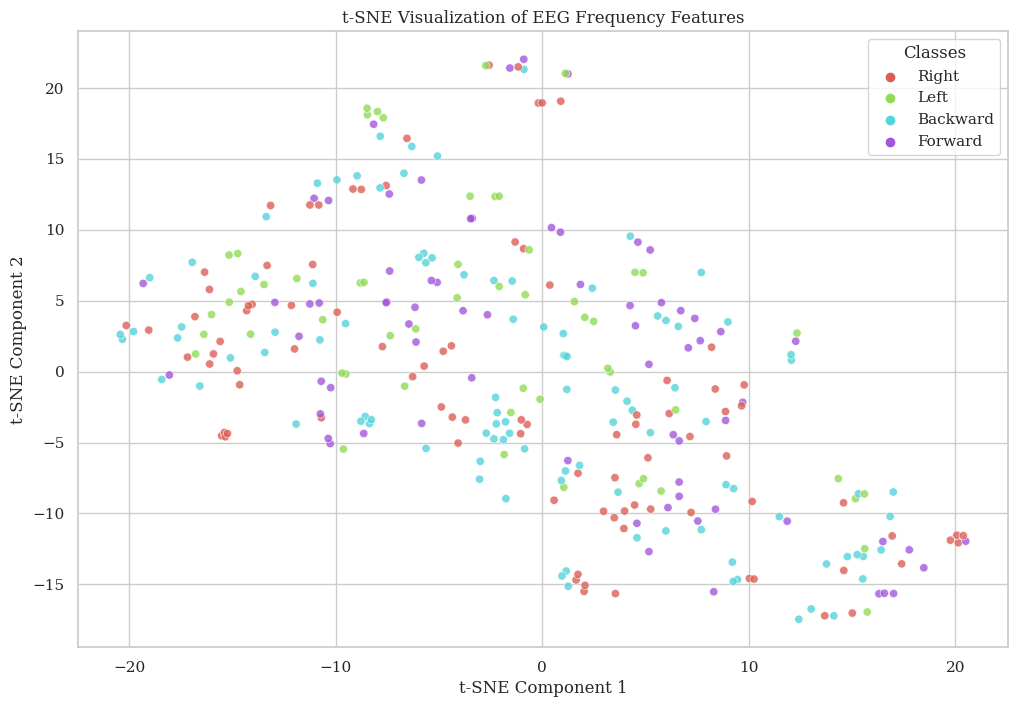

In [58]:
num_batches_for_tsne = 5
features_list = []
labels_list = []

# Get data from the train_loader
for i, (features, labels) in enumerate(train_loader):
    if i >= num_batches_for_tsne:
        break
    features_list.append(features.numpy())
    labels_list.append(labels.numpy())
    print(f"Loaded batch {i+1}/{num_batches_for_tsne}")

# Concatenate all the batches into single numpy arrays
all_features = np.concatenate(features_list, axis=0)
all_labels = np.concatenate(labels_list, axis=0)

# --- 2. Prepare Data for t-SNE ---

# The data shape is (n_samples, n_channels, n_freq_bins).
# We need to flatten it to (n_samples, n_channels * n_freq_bins).
n_samples = all_features.shape[0]
flattened_features = all_features.reshape(n_samples, -1)

print(f"Data prepared for t-SNE with shape: {flattened_features.shape}")

# --- 3. Run the t-SNE Algorithm ---

print("Running t-SNE... (this may take a moment)")
tsne = TSNE(
    n_components=2,      # We want a 2D plot
    verbose=1,           # Print progress
    perplexity=30,       # A good default value, relates to # of nearest neighbors
    learning_rate='auto',
    init='pca'
)
tsne_results = tsne.fit_transform(flattened_features)

print("t-SNE completed.")

# --- 4. Plot the Results ---

# Create a pandas DataFrame for easier plotting with seaborn
df_tsne = pd.DataFrame(tsne_results, columns=['tsne-2d-one', 'tsne-2d-two'])
# Map numeric labels to class names
df_tsne['label'] = [LABELS[l] for l in all_labels] 

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 4), # Use 4 distinct colors for the 4 classes
    data=df_tsne,
    legend="full",
    alpha=0.8 # Set transparency of points
)

plt.title('t-SNE Visualization of EEG Frequency Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Classes')
plt.show()

In [27]:
unique = dataset.labels.unique()
for c in unique:
    print((dataset.labels == c).sum())
len(dataset), dataset.data.shape

tensor(7765)
tensor(7143)
tensor(7227)
tensor(7387)


(29522, torch.Size([29522, 8, 350]))

In [45]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class DepthWiseConv2D(nn.Module):
    def __init__(self, in_channels, kernel_size, dim_mult=1, padding=0, bias=False):
        super(DepthWiseConv2D, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels * dim_mult, padding=padding, kernel_size=kernel_size, groups=in_channels, bias=bias)

    def forward(self, x: torch.Tensor):
        return self.depthwise(x)


class SeperableConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, bias=False):
        super(SeperableConv2D, self).__init__()
        self.depthwise = DepthWiseConv2D(in_channels, kernel_size, padding=padding)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class SSVEPClassifier(nn.Module):
    # EEG Net Based
    # todo look at this https://paperswithcode.com/paper/a-transformer-based-deep-neural-network-model
    def __init__(self, n_electrodes=16, out_dim=4, dropout=0.25, kernLength=256, F1=96, D=1, F2=96, hidden_dim=100, layer_dim=1):
        super().__init__()

        # B x C x T
        self.block_1 = nn.Sequential(
            nn.Conv2d(1, F1, (1, kernLength), padding='same', bias=False),
            nn.BatchNorm2d(F1),
            #
            DepthWiseConv2D(F1, (n_electrodes, 1), dim_mult=D, bias=False),
            nn.BatchNorm2d(F1*D),
            nn.ELU(),
            nn.MaxPool2d((1, 2)), # todo try making this max pool
            nn.Dropout(dropout),
            #
            SeperableConv2D(F1 * D, F2, kernel_size=(1, 16), padding='same', bias=False),
            nn.BatchNorm2d(F2),
            nn.ELU(),
            nn.MaxPool2d((1, 2)),
            nn.Dropout(dropout),
        )

        self.lstm_head = LSTMModel(F2, hidden_dim, layer_dim, out_dim)

    def forward(self, x: torch.Tensor):
        """expected input shape: BxCxT"""
        x = x.unsqueeze(1)
        y = self.block_1(x) # B x F1 x 1 x time_sub

        y = y.squeeze(2) # B x F1 x time_sub
        y = y.permute(0, 2, 1) # B x time_sub x F1
        y = self.lstm_head(y)

        return y

dummy_x = torch.randn(5, 3, 256).to(device)
model = SSVEPClassifier(
    n_electrodes=3,
    dropout=0.33066508963955576,
    kernLength=64,
    F1 = 8,
    D = 2,
    F2 = 32,
    hidden_dim=256,
    layer_dim=2,
).to(device)

model(dummy_x)

/home/zeyadcode/.pyenv/versions/icmtc_venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv2d(


tensor([[-0.0128,  0.0775, -0.0415,  0.0102],
        [-0.0057,  0.0677, -0.0365,  0.0142],
        [-0.0119,  0.0590, -0.0288,  0.0196],
        [-0.0171,  0.0640, -0.0281,  0.0206],
        [-0.0048,  0.0695, -0.0308,  0.0203]], grad_fn=<AddmmBackward0>)

In [ ]:
try:
    model.load_state_dict(torch.load(model_path, weights_only=True))
except Exception:
    print("skipping model loading...")


opt = torch.optim.Adam(model.parameters(), lr=0.00030241790493218325)
criterion = nn.CrossEntropyLoss()
avg_losses = []
val_accuracies = []

epochs = 200
for epoch in range(epochs):
    avg_loss = 0
    model.train()
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x).to(device)

        loss = criterion(y_pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        avg_loss += loss.item()

    avg_loss /= len(train_loader)
    avg_losses.append(avg_loss)

    if epoch % 5 == 0:
        evaluation = evaluate_model(model, test_loader, device)
        val_accuracies.append(evaluation)
        model.cpu()
        torch.save(model.state_dict(), model_path)
        model.to(device)
        print(f"epoch: {epoch}, avg_loss: {avg_loss}, val_evaluation: {evaluation}")

epoch: 0, avg_loss: 1.81864476435956, val_evaluation: 0.3155517578125


KeyboardInterrupt: 

In [ ]:
# maxpool
plt.plot(range(len(avg_losses)), avg_losses, "b-", label="trainingg loss")
plt.plot(range(len(val_accuracies)), val_accuracies, "r-", label="validation accuracies")
plt.legend()
print(f"min avg_losses: {min(avg_losses)}")
print(f"max val_accuracies: {max(val_accuracies)}")

NameError: name 'avg_losses' is not defined

In [ ]:
batch_size = 64
window_length = 175
stride_factor=3

In [ ]:
class CustomTrainer(Trainer):
    def _prepare_training(self, is_trial, do_not_modify_network=True, batch_size=batch_size, window_length=window_length, stride_factor=stride_factor):
        super()._prepare_training(is_trial, do_not_modify_network, batch_size=batch_size,
                                  window_length=window_length,
                                  stride_factor=stride_factor, is_wavelet=True)
        assert self.dataset is not None

        if is_trial:
            assert isinstance(self.trial, optuna.Trial), "trial is none, cant' suggest params"

            if do_not_modify_network:
                best_params = self._get_study().best_params if do_not_modify_network else None
                assert best_params is not None, "best_params is None, can't use them"

                kernLength = best_params["kernLength"]
                F1 = best_params["F1"]
                D = best_params["D"]
                F2 = best_params["F2"]
                hidden_dim = best_params["hidden_dim"]
                layer_dim = best_params["layer_dim"]

            else:
                kernLength = self.trial.suggest_categorical("kernLength", [128, 256, 512])
                F1 = self.trial.suggest_categorical("F1", [64, 96, 128])
                D = self.trial.suggest_categorical("D", [1, 2, 3])
                F2 = self.trial.suggest_categorical("F2", [64, 96, 128])
                hidden_dim = self.trial.suggest_categorical("hidden_dim", [64, 128, 256])
                layer_dim = self.trial.suggest_categorical("layer_dim", [1, 2, 3, 4])

            dropout = self.trial.suggest_float("dropout", 0, 0.5)
            lr = self.trial.suggest_float("lr", 3e-4, 3e-2, log=True)
        else:
            # best_params = self._get_study().best_params
            # kernLength = best_params["kernLength"]
            # F1 = best_params["F1"]
            # D = best_params["D"]
            # F2 = best_params["F2"]
            # hidden_dim = best_params["hidden_dim"]
            # layer_dim = best_params["layer_dim"]
            # dropout = best_params["dropout"]
            # lr = best_params["lr"]
            dropout=0.33066508963955576
            kernLength=256
            F1 = 128
            D = 2
            F2 = F1 # OOPS 96
            hidden_dim=256
            layer_dim=3
            lr = 0.000010241790493218325

        n_samples = self.dataset.data[0].shape[1]  # data[x] shape CxT
        n_electrodes = self.dataset.data[0].shape[0]

        n_samples = self.dataset.data[0].shape[1]  # data[x] shape CxT
        n_electrodes = self.dataset.data[0].shape[0]

        self.model = SSVEPClassifier(
            n_electrodes=n_electrodes, n_samples=n_samples, out_dim=4, dropout=dropout, kernLength=kernLength, F1=F1, D=D, F2=F2, hidden_dim=hidden_dim, layer_dim=layer_dim
        )
        print(f"lr: {lr}")
        try:
            self.model.load_state_dict(torch.load(model_path))
            print(f"loaded model weights")
        except Exception:
            print(f"no model weights found at {model_path}")
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

trainer = CustomTrainer(data_path, optuna_db_path, model_path, train_epochs=10000, optuna_n_trials=35)

In [ ]:
delete_existing = False
trainer.optimize(delete_existing)

[I 2025-06-20 18:42:30,753] Using an existing study with name 'ssvep_classifier_optimization' instead of creating a new one.
[I 2025-06-20 18:42:30,815] Using an existing study with name 'ssvep_classifier_optimization' instead of creating a new one.
[W 2025-06-20 18:42:30,839] Trial 0 failed with parameters: {} because of the following error: ValueError('Record does not exist.').
Traceback (most recent call last):
  File "/home/zeyadcode/.pyenv/versions/icmtc_venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/home/zeyadcode/Workspace/ai_projects/eeg_detection/modules/trainer.py", line 101, in _objective
    self._prepare_training(True)
  File "/tmp/ipykernel_306525/3387801006.py", line 3, in _prepare_training
    super()._prepare_training(is_trial, do_not_modify_network, batch_size=batch_size,
  File "/home/zeyadcode/Workspace/ai_projects/eeg_detection/modules/trainer.py", li

ValueError: Record does not exist.

In [ ]:
# manual_write_study_params(trainer.study_name, trainer.storage)
trainer.train()

In [ ]:
trainer._prepare_training(False)
trainer.model.eval()
f"test accuracy: {evaluate_model(trainer.model, trainer.test_loader, device)}"

lr: 1.0241790493218325e-05
loaded model weights


'test accuracy: 0.74484375'

In [ ]:
# %%
from torch.utils.data import Dataset
import os
import numpy as np
import pandas as pd
import torch
from scipy.fft import fft, rfft
from scipy import signal
from numpy.lib.stride_tricks import sliding_window_view


LABELS = ['Backward', 'Forward', 'Left', 'Right']
LABEL_TO_IDX = {lbl: i for i, lbl in enumerate(LABELS)}
IDX_TO_LABEL = {idx: label for idx, label in enumerate(LABELS)}

# Precompute filter once
_SFREQ    = 256
_LOW, _HI = 3, 100
_NYQ      = _SFREQ / 2.0
_B, _A    = signal.butter(4, [_LOW/_NYQ, _HI/_NYQ], btype='bandpass')


In [ ]:
fn = "./data/mtcaic3/SSVEP/validation/S35/1/EEGdata.csv"
torch.set_printoptions(sci_mode=False, precision=6)
#correct is backward, forwaard, left, right

def avg_refrencing(data: np.ndarray):
    return data - data.mean(axis=2, keepdims=True)

def band_pass_filter(data: np.ndarray):
    return signal.filtfilt(_B, _A, data, axis=2)

def normalize(data: np.ndarray):
    mean = data.mean(axis=2, keepdims=True)
    std  = data.std(axis=2, keepdims=True) + 1e-6
    data = (data - mean) / std
    return data

cols = ['FZ','C3','CZ','C4','PZ','PO7','OZ','PO8']

df = pd.read_csv(fn, usecols=cols)
df_valid = pd.read_csv(fn, usecols=['Validation'])
last175 = df

i = 7
tensor = torch.tensor(last175.values, dtype=torch.float32)[-1750 * i:-1750 * (i - 1), :].view(10, 175, 8).permute(0, 2, 1)
valid_tensor = torch.tensor(df_valid.values, dtype=torch.float32)[-1750 * i:-1750 * (i - 1), :].view(10, 175, 1)
print((valid_tensor == 0).sum())
print(tensor[-1][:, 0])
data_array = avg_refrencing(tensor.numpy())
data_array = band_pass_filter(data_array)
data_array = normalize(data_array)

tensor = torch.from_numpy(data_array.copy()).to(torch.float32)
print(tensor.shape)
trainer.model.eval()
print(torch.softmax(trainer.model(tensor), dim=1))
print(torch.argmax(trainer.model(tensor), dim=1))

tensor(0)
tensor([285661.468750, 299282.437500, 351748.000000, 387430.937500,
        429527.781250, 281785.593750, 272474.312500, 271807.593750])
torch.Size([10, 8, 175])


AttributeError: 'NoneType' object has no attribute 'eval'

In [ ]:
# 1. Your target tensor (shape [8,175])
target = tensor[0]  

# 2. Grab the underlying Dataset
ds = trainer.train_loader.dataset

best_dist = float('inf')
best_label = None
best_data = None

# 3. Iterate over every sample in the Dataset
for i in range(len(ds)):
    item = ds[i]
    # unpack data & label
    if isinstance(item, (tuple, list)):
        data_i, label_i = item[0], item[1]
    elif isinstance(item, dict):
        # adjust key names if needed
        data_i, label_i = item.get('eeg', item.get('data')), item['label']
    else:
        continue

    # convert numpy → torch if necessary
    if isinstance(data_i, np.ndarray):
        data_i = torch.from_numpy(data_i)

    # ensure same shape
    data_i = data_i.view_as(target)

    # compute Euclidean distance
    dist = torch.norm(data_i - target).item()

    if dist < best_dist:
        best_dist = dist
        best_label = label_i
        best_data = data_i

print(best_data)
# 4. Print the label of the most similar sample
print(best_label)


tensor([[ 0.014051,  0.760070, -0.390054,  ...,  1.452694,  0.092904,
          0.152871],
        [ 0.080737, -1.386883, -1.813527,  ..., -2.237866, -1.017529,
          0.188362],
        [ 0.061857,  0.087862, -1.565250,  ...,  0.266991, -0.599239,
          0.293950],
        ...,
        [ 0.075408, -1.377178, -1.511927,  ..., -2.300731, -0.829118,
          0.133468],
        [ 0.075436, -1.367463, -1.623659,  ..., -2.319957, -0.983773,
          0.143160],
        [ 0.112787, -1.282061, -2.147263,  ..., -2.190778, -1.087937,
          0.217843]])
tensor(0)


In [ ]:
tensor[0]

tensor([[     7.525880,    366.709625,   -187.037323,  ...,
            700.185608,     45.491299,     74.363281],
        [    -1.113108,   -418.527405,   -539.871704,  ...,
           -660.560547,   -313.477386,     29.497141],
        [     4.467845,     13.405240,   -554.742981,  ...,
             74.969322,   -222.740326,     84.234581],
        ...,
        [    -0.338264,   -185.773224,   -202.974960,  ...,
           -303.672516,   -115.808647,      7.073462],
        [    -1.511939,   -404.904968,   -476.529968,  ...,
           -671.194824,   -297.636383,     17.421761],
        [     1.490031,   -154.565750,   -251.364700,  ...,
           -256.233124,   -132.847198,     13.243663]])